In [1]:
import sys 
from extraction.extract import *
import math
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from datetime import datetime
sys.path.append(".")

GENERAL

Our model right now takes a month of data, trains on the first 20 days of the month and makes predicitons for the rest 11 days. It uses the column "timeslot" as the index and makes a prediction for "departuresDepartureDelay" and "arrivalsArrivalDelay". Right now we use a time interval of 15 minutes and use a lookback of one time slot which is equivalent to 15 minutes.

DATA PREPARATION

Currently with data preparation we have the data being separated and indexed with the timeslot that is a datetime object including year-month-day-time. The idea was a linear model that just uses past data to calculate the labels which are "departuresDepartureDelay" and "arrivalsArrivalDelay". However we ran into the problem of the discontinuity of the data. We only have data for months 3, 6, 9 and 12. So in between the months we have a time interval of 3 months instead of our normal times step of 15 minutes. We had a meeting with Mr. Junzi and he said that instead of having such a continous model we could just make a model that feeds day by day individually. In this case we need to consider the lookback and not include it in the predictions. e.g. if we have a lookback of 3 hours the predictions only start after 03:00 am. 

Some questions we are trying to solve right now is:

    - How do we structure the data such that the model can feed each day individually? The model we considered for this implementation is considering continuous data so we might want to look at other examples and see how they do it
    - How would we have each day only be trained after a cetrain time? Like 03:00 am?

We were also in the process of changing the time step to one hour time intervals. 

The cell below is to remove empty days from the dataset. To be continued

In [2]:
# dataset = generateNNdata("EGLL", timeslotLength=15, catagoricalFlightDuration=False)
# dataset = dataset.set_index("timeslot")
# for i in dataset.index:
#     if (i.year == 2018 and i.month not in [3, 6, 9, 12]) or (i.year == 2019 and i.month not in [3, 6, 9]):
#         dataset.drop(i, axis = 0, inplace = True)

# display(dataset)

What we are doing here is the following:

    - Generate data from the file
    - Drop some columns and rearrage the data such that our labels are the last two columns of the dataset
    - Filter thae data to one month of data   
    - Normaliza data  
    - Put our data in the form that LSTM is using to train it. With the function: series_to_supervised

In [3]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# Generate single airport data and move target labels to the last 2 columns 

dataset = generateNNdata("EGLL", timeslotLength=15, catagoricalFlightDuration=False, start=datetime(2019, 3, 1), end=datetime(2019, 3, 1))
dataset = dataset.set_index("timeslot")


dataset.drop(columns=['departuresArrivalDelay','arrivalsDepartureDelay'])

label1 = dataset.pop('departuresDepartureDelay')
dataset.insert(len(dataset.columns), 'departuresDepartureDelay', label1)

label2 = dataset.pop('arrivalsArrivalDelay')
dataset.insert(len(dataset.columns), 'arrivalsArrivalDelay', label2)

display(dataset)

# Use a certain number of months/days of Data 

number_of_months = 1
number_of_days = 1
index_slice = number_of_days * 4 * 24 
dataset = dataset.iloc[0:index_slice]

# summarize first 5 rows
print(dataset.head(75))

# Normalize values
values = dataset.values
display(values)

# ensure all data is float

values = values.astype('float32')

# normalize features

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning

number_of_past_steps = 1
number_of_future_steps = 4
reframed = series_to_supervised(scaled, n_in=number_of_past_steps, n_out=number_of_future_steps)

# drop columns we don't want to predict

reframed.drop(columns=reframed.columns[[i for i in range(len(reframed.columns)-20, len(reframed.columns)-2)]], inplace=True)
display(reframed)

,departing,arriving,lowcost,arrivalsFlightDuration,arrivalsDepartureDelay,departuresFlightDuration,departuresArrivalDelay,planes,capacityFilled,weekend,winter,spring,summer,autumn,night,morning,afternoon,evening,departuresDepartureDelay,arrivalsArrivalDelay
timeslot,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,1,0,0.0,0.0,0.0,402.0,62.0,-1,0.011364,0,0,1,0,0,1,0,0,0,24.0,0.0
2018-03-01 00:15:00,1,0,0.0,0.0,0.0,388.0,-25.0,-1,0.011364,0,0,1,0,0,1,0,0,0,-20.0,0.0
2018-03-01 00:30:00,1,0,0.0,0.0,0.0,260.0,-7.0,-1,0.011364,0,0,1,0,0,1,0,0,0,-4.0,0.0
2018-03-01 00:45:00,1,1,0.0,53.0,-4.0,249.0,36.0,0,0.022727,0,0,1,0,0,1,0,0,0,10.0,-14.0
2018-03-01 01:00:00,1,0,0.0,0.0,0.0,408.0,-24.0,-1,0.011364,0,0,1,0,0,1,0,0,0,-14.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-01 10:45:00,0,0,0.0,0.0,0.0,0.0,0.0,0,0.000000,0,0,0,0,1,0,1,0,0,0.0,0.0
2019-10-01 11:00:00,0,0,0.0,0.0,0.0,0.0,0.0,0,0.000000,0,0,0,0,1,0,1,0,0,0.0,0.0
2019-10-01 11:15:00,0,0,0.0,0.0,0.0,0.0,0.0,0,0.000000,0,0,0,0,1,0,1,0,0,0.0,0.0


                     departing  arriving   lowcost  arrivalsFlightDuration  \
timeslot                                                                     
2018-03-01 00:00:00          1         0  0.000000                0.000000   
2018-03-01 00:15:00          1         0  0.000000                0.000000   
2018-03-01 00:30:00          1         0  0.000000                0.000000   
2018-03-01 00:45:00          1         1  0.000000               53.000000   
2018-03-01 01:00:00          1         0  0.000000                0.000000   
...                        ...       ...       ...                     ...   
2018-03-01 17:30:00          7         7  0.071429              221.571429   
2018-03-01 17:45:00          2         4  0.000000              364.250000   
2018-03-01 18:00:00          9         6  0.000000              311.333333   
2018-03-01 18:15:00          5         4  0.000000              275.750000   
2018-03-01 18:30:00          4         6  0.000000              

array([[  1.,   0.,   0., ...,   0.,  24.,   0.],
       [  1.,   0.,   0., ...,   0., -20.,   0.],
       [  1.,   0.,   0., ...,   0.,  -4.,   0.],
       ...,
       [  6.,   0.,   0., ...,   1.,   1.,   0.],
       [  1.,   0.,   0., ...,   1.,  15.,   0.],
       [  0.,   0.,   0., ...,   1.,   0.,   0.]])

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var13(t+2),var14(t+2),var15(t+2),var16(t+2),var17(t+2),var18(t+2),var19(t+2),var20(t+2),var19(t+3),var20(t+3)
1,0.0625,0.000000,0.0,0.000000,0.208333,0.559110,1.000000,0.470588,0.043478,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.463320,0.000000,0.092664,0.218750
2,0.0625,0.000000,0.0,0.000000,0.208333,0.539638,0.000000,0.470588,0.043478,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.092664,0.218750,0.308880,0.218750
3,0.0625,0.000000,0.0,0.000000,0.208333,0.361613,0.206897,0.470588,0.043478,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.308880,0.218750,0.308880,0.218750
4,0.0625,0.076923,0.0,0.108218,0.125000,0.346314,0.701149,0.529412,0.086957,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.308880,0.218750,0.308880,0.218750
5,0.0625,0.000000,0.0,0.000000,0.208333,0.567455,0.011494,0.470588,0.043478,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.308880,0.218750,0.308880,0.218750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,0.3125,0.153846,0.0,0.192956,0.625000,0.643672,0.450575,0.352941,0.304348,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.554269,0.390625,0.308880,0.031250
89,0.5000,0.153846,0.0,0.337928,0.218750,0.755042,0.508621,0.176471,0.434783,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.308880,0.031250,0.540541,0.335938
90,0.1250,0.384615,0.0,0.344666,0.287500,0.653686,0.178161,0.705882,0.304348,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.540541,0.335938,0.324324,0.218750
91,0.5625,0.153846,0.0,0.436958,0.395833,0.522485,0.412516,0.117647,0.478261,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.324324,0.218750,0.540541,0.218750


DEFINE AND FIT MODEL

Instead of days we use hours to train the model. We split the data to the first 18 hours of the day and predict the rest 6. Right now we are doing it for only one day. What we need to do instead is to train the model with a lot of days individually and then initiate the model in a certain time that'll be determined by our lookback and and start predicting after that time for a new set of days.

Shape of dataset: (92, 82)
Shape of train dataset: (72, 82)
Shape of test dataset: (20, 82)
(72, 80)
(72, 1, 80) (72, 2) (20, 1, 80) (20, 2)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                26200     
                                                                 
 dense (Dense)               (None, 2)                 102       
                                                                 
Total params: 26,302
Trainable params: 26,302
Non-trainable params: 0
_________________________________________________________________
Epoch 1/75
1/1 [==============================] - 3s 3s/step - loss: 0.4960 - val_loss: 0.3831
Epoch 2/75
1/1 [==============================] - 0s 29ms/step - loss: 0.4645 - val_loss: 0.3548
Epoch 3/75
1/1 [==============================] - 0s 30ms/step - loss: 0.4329 - val_loss: 0.3263
Epoch 4/75
1/1 [==

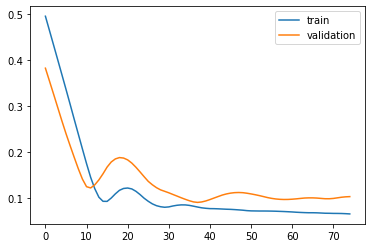

In [4]:
values = reframed.values
# number_of_days_to_train = 20
number_of_hours_to_train = 18
number_of_timeslots_in_one_hour = 4 # 4 for 15 minute intervals, 1 for 1 hour intervals
train_index = number_of_hours_to_train * number_of_timeslots_in_one_hour

# split into train, test and validation sets

train = values[:(train_index), :]
#validation = values[(train_index-30):train_index, :]
test = values[train_index:, :]

print('Shape of dataset:', reframed.shape)
print('Shape of train dataset:', train.shape)
print('Shape of test dataset:', test.shape)
#print('Shape of validation dataset:', validation.shape)

# split into input and outputs

train_X, train_y = train[:, :-2], train[:, -2:]
test_X, test_y = test[:, :-2], test[:, -2:]
#val_X, val_y = validation[:, :-1], validation[:, -1]
print(train_X.shape)

# reshape input to be 3D [samples, timesteps, features]

train_X = train_X.reshape((train_X.shape[0], -1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], -1, test_X.shape[1]))
#val_X = val_X.reshape((val_X.shape[0], number_of_time_steps, val_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) #val_X.shape, val_y.shape)


# design network

model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(2))
model.compile(loss='mae', optimizer='adam')
model.summary()

# fit network

history = model.fit(train_X, train_y, epochs=75, batch_size=72, validation_data = (test_X, test_y), verbose=1, shuffle=False) #validation_data=(val_X, val_y),

# plot history

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')
pyplot.legend()
pyplot.show()

In [5]:
# Generate predictions

print(test_X.shape)
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
print(test_X.shape)

# See predictions and real values

print(yhat)
print(test_y)
print(yhat.shape)

# Split and reshape the two desired outputs in separate arrays to prepare for inverse scaling

yhat1 = yhat[:, 0]
yhat2 = yhat[:, 1]
yhat1 = yhat1.reshape(len(yhat), 1)
yhat2 = yhat2.reshape(len(yhat), 1)
print(yhat1.shape, yhat2.shape)

# Also split the real values of the labels and reshape for inverse scaling

print(test_y.shape)
test_y_1 = test_y[:, 0]
test_y_2 = test_y[:, 1]
test_y_1 = test_y_1.reshape(len(test_y), 1)
test_y_2 = test_y_2.reshape(len(test_y), 1)
print(test_y_1.shape, test_y_2.shape)

(20, 1, 80)
(20, 80)
[[0.55487967 0.53367335]
 [0.6013365  0.510089  ]
 [0.6004902  0.4860337 ]
 [0.6116271  0.5459246 ]
 [0.6113409  0.5136193 ]
 [0.6114719  0.4380374 ]
 [0.584602   0.52948993]
 [0.58381116 0.53441155]
 [0.59373033 0.50427926]
 [0.5987191  0.49498546]
 [0.55544615 0.5474456 ]
 [0.55923223 0.5173357 ]
 [0.5285288  0.49157196]
 [0.5262778  0.46366134]
 [0.45357227 0.47367713]
 [0.49516594 0.4354262 ]
 [0.37895426 0.39749923]
 [0.4377816  0.3944632 ]
 [0.38123748 0.33645642]
 [0.38724697 0.3568726 ]]
[[0.58000857 0.47544643]
 [0.64478767 0.4427083 ]
 [0.60849416 0.5494791 ]
 [0.45077217 0.484375  ]
 [0.45817244 0.46875   ]
 [0.40595695 0.4888393 ]
 [0.5336765  0.48660713]
 [0.53392166 0.4955357 ]
 [0.5765766  0.4114583 ]
 [0.7155727  0.48632812]
 [0.42140096 0.378125  ]
 [0.54980695 0.421875  ]
 [0.66602314 0.3828125 ]
 [0.36293435 0.2625    ]
 [0.55426854 0.390625  ]
 [0.3088803  0.03125   ]
 [0.5405405  0.3359375 ]
 [0.3243243  0.21875   ]
 [0.5405405  0.21875   ]
 [0

EVALUATE MODEL AND VISUALIZE PREDICTIONS

Here we inverse the scaling of the labels to get their actual value and calculate the MAE. It'd be useful to create a Normal distribution of the labels so that we know our confidence intervals

In [6]:
# Inverse transform the predictions

inv_yhat_1 = concatenate((yhat1, yhat2, test_X[:, 0:18]), axis=1)
inv_yhat_1 = scaler.inverse_transform(inv_yhat_1)
inv_yhat_1 = inv_yhat_1[:, :2]

print("inv_yhat_1: ", inv_yhat_1)

# Inverse transform the real values of the labels

inv_y_1 = concatenate((test_y_1, test_y_2, test_X[:, 0:18]), axis=1)
inv_y_1 = scaler.inverse_transform(inv_y_1)
inv_y_1 = inv_y_1[:, :2]

print("inv_y_1: ", inv_y_1)

# calculate MAE between predicted and actual labels

mae1 = mean_absolute_error(inv_y_1[:, 0], inv_yhat_1[:, 0])
mae2 = mean_absolute_error(inv_y_1[:, 1], inv_yhat_1[:, 1])

print('Test MAE1: %.3f' % mae1)
print('Test MAE2: %.3f' % mae2)


inv_yhat_1:  [[8.878075  6.937753 ]
 [9.621384  6.6311564]
 [9.607843  6.318438 ]
 [9.786034  7.0970197]
 [9.781454  6.6770506]
 [9.78355   5.694486 ]
 [9.353632  6.883369 ]
 [9.340979  6.94735  ]
 [9.499685  6.55563  ]
 [9.579506  6.4348106]
 [8.887138  7.1167927]
 [8.947716  6.725364 ]
 [8.456461  6.390435 ]
 [8.4204445 6.0275974]
 [7.2571564 6.1578026]
 [7.922655  5.6605406]
 [6.063268  5.16749  ]
 [7.0045056 5.1280217]
 [6.0997996 4.3739333]
 [6.1959515 4.6393433]]
inv_y_1:  [[ 9.280137    6.1808033 ]
 [10.316603    5.755208  ]
 [ 9.735907    7.1432285 ]
 [ 7.2123547   6.296875  ]
 [ 7.330759    6.09375   ]
 [ 6.4953113   6.354911  ]
 [ 8.538824    6.3258924 ]
 [ 8.542747    6.4419637 ]
 [ 9.225225    5.348958  ]
 [11.449163    6.3222656 ]
 [ 6.7424154   4.915625  ]
 [ 8.796911    5.484375  ]
 [10.65637     4.9765625 ]
 [ 5.8069496   3.4124997 ]
 [ 8.868297    5.078125  ]
 [ 4.942085    0.40624997]
 [ 8.648648    4.3671875 ]
 [ 5.189189    2.84375   ]
 [ 8.648648    2.84375   ]
 [ 

NON SCALED LABELS

This is an attempt to see how the model would wok if we don't scale the outputs. However it's a bit outdated 

In [7]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg



dataset = generateNNdata("EHAM", timeslotLength=15, catagoricalFlightDuration=False)
dataset = dataset.set_index("timeslot")


dataset.drop(columns=['departuresArrivalDelay','arrivalsArrivalDelay'])
label = dataset.pop('departuresDepartureDelay')
dataset.insert(len(dataset.columns), 'departuresDepartureDelay', label)

# Get first month of Data
number_of_months = 1
index_slice = number_of_months * 4 * 24 * 31 - 1
dataset = dataset.iloc[0:index_slice]

# summarize first 5 rows
display(dataset)

# Normalize values
values = dataset.values
# display(values)
X, y = values[:,:-1], values[:,-1]
display(X)
display(y)
print(y.shape)
print(type(X), type(y))
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(X)
# display(scaled)
y = y.reshape((len(y), 1))
scaled = concatenate((X, y), axis=1)
display(scaled)
# frame as supervised learning
number_of_time_steps = 1
number_of_outputs = 1
reframed = series_to_supervised(scaled, n_in=number_of_time_steps, n_out=number_of_outputs)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[i for i in range(20,39)]], axis=1, inplace=True)  # I don't think we need this, but not sure
display(reframed)

,departing,arriving,lowcost,arrivalsFlightDuration,arrivalsDepartureDelay,arrivalsArrivalDelay,departuresFlightDuration,departuresArrivalDelay,planes,capacityFilled,weekend,winter,spring,summer,autumn,night,morning,afternoon,evening,departuresDepartureDelay
timeslot,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:15:00,1,0,1.00,0.0,0.000000,0.0,183.0,15.0,-1,0.01,0,0,1,0,0,1,0,0,0,12.0
2018-03-01 00:30:00,0,0,0.00,0.0,0.000000,0.0,0.0,0.0,0,0.00,0,0,1,0,0,1,0,0,0,0.0
2018-03-01 00:45:00,0,0,0.00,0.0,0.000000,0.0,0.0,0.0,0,0.00,0,0,1,0,0,1,0,0,0,0.0
2018-03-01 01:00:00,0,0,0.00,0.0,0.000000,0.0,0.0,0.0,0,0.00,0,0,1,0,0,1,0,0,0,0.0
2018-03-01 01:15:00,0,1,1.00,57.0,9.000000,47.0,0.0,0.0,1,0.01,0,0,1,0,0,1,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-31 22:45:00,0,0,0.00,0.0,0.000000,0.0,0.0,0.0,0,0.00,1,0,1,0,0,0,0,0,1,0.0
2018-03-31 23:00:00,0,0,0.00,0.0,0.000000,0.0,0.0,0.0,0,0.00,1,0,1,0,0,0,0,0,1,0.0
2018-03-31 23:15:00,1,3,0.75,192.0,-7.333333,-13.0,673.0,16.0,2,0.04,1,0,1,0,0,0,0,0,1,12.0


array([[1.  , 0.  , 1.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       ...,
       [1.  , 3.  , 0.75, ..., 0.  , 0.  , 1.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 1.  ],
       [1.  , 0.  , 1.  , ..., 0.  , 0.  , 1.  ]])

array([12.,  0.,  0., ..., 12.,  0., -7.])

(2975,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


array([[ 1.  ,  0.  ,  1.  , ...,  0.  ,  0.  , 12.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       ...,
       [ 1.  ,  3.  ,  0.75, ...,  0.  ,  1.  , 12.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  1.  ,  0.  ],
       [ 1.  ,  0.  ,  1.  , ...,  0.  ,  1.  , -7.  ]])

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var12(t-1),var13(t-1),var14(t-1),var15(t-1),var16(t-1),var17(t-1),var18(t-1),var19(t-1),var20(t-1),var20(t)
1,1.0,0.0,1.00,0.0,0.000000,0.0,183.0,15.0,-1.0,0.01,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,12.0,0.0
2,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,0.0,1.0,1.00,57.0,9.000000,47.0,0.0,0.0,1.0,0.01,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2970,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2971,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2972,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,12.0
2973,1.0,3.0,0.75,192.0,-7.333333,-13.0,673.0,16.0,2.0,0.04,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,12.0,0.0


Shape of dataset: (2974, 21)
Shape of train dataset: (1920, 21)
Shape of test dataset: (1054, 21)
(1920, 1, 20) (1920,) (1054, 1, 20) (1054,)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                14200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 14,251
Trainable params: 14,251
Non-trainable params: 0
_________________________________________________________________
Epoch 1/75
27/27 [==============================] - 2s 19ms/step - loss: 4.7380 - val_loss: 4.5291
Epoch 2/75
27/27 [==============================] - 0s 8ms/step - loss: 4.4211 - val_loss: 4.2879
Epoch 3/75
27/27 [==============================] - 0s 8ms/step - loss: 4.3001 - val_loss: 4.2089
Epoch 4/7

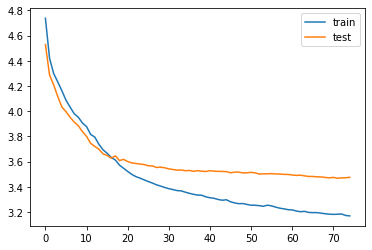

In [8]:
# split into train and test sets
values = reframed.values
number_of_days_to_train = 20
number_of_timeslots_in_one_hour = 4 # 4 for 15 minute intervals, 1 for 1 hour intervals
train_index = number_of_days_to_train * 24 * number_of_timeslots_in_one_hour

train = values[:train_index, :]
test = values[train_index:, :]

print('Shape of dataset:', reframed.shape)
print('Shape of train dataset:', train.shape)
print('Shape of test dataset:', test.shape)

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], -1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], -1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
model.summary()
# fit network
history = model.fit(train_X, train_y, epochs=75, batch_size=72, validation_data=(test_X, test_y), verbose=1, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


In [9]:
# make a prediction
yhat = model.predict(test_X)

# calculate MAE
mae = mean_absolute_error(test_y, yhat)
print('Test MAE: %.3f' % mae)

Test MAE: 3.475
